# Data Preparation

Cleaned Columns: ['car_name', 'year', 'selling_price', 'present_price', 'kms_driven', 'fuel_type', 'seller_type', 'transmission', 'owner']
Dataset Preview:
  car_name  year  selling_price  present_price  kms_driven fuel_type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  seller_type transmission  owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  

Mean selling price across all cars: 4.661295681063123
Minimum kilometers driven to be in the top 10%: 65000.0
Number of qualified cars: 31


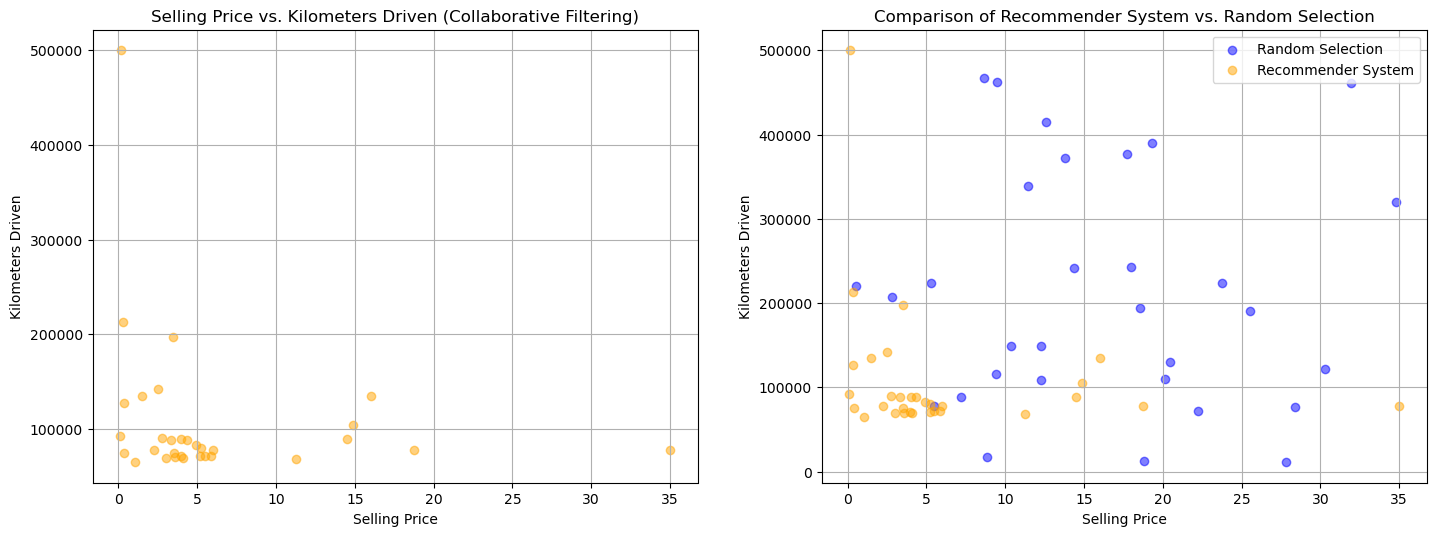

Car name 'Maruti Swift Dzire VDI' not found in the dataset.

Collaborative filtering model saved successfully.
Car name 'Maruti Swift Dzire VDI' not found in the dataset.

Content-based filtering model saved successfully.


In [36]:
import pandas as pd
import numpy as np
import difflib
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Load and clean dataset
car_data = pd.read_csv('car data.csv')
car_data.columns = car_data.columns.str.strip().str.lower().str.replace(' ', '_')
print("Cleaned Columns:", car_data.columns.tolist())

# Preview dataset
print("Dataset Preview:")
print(car_data.head())

# Fill missing values
car_data.fillna(0, inplace=True)

# Calculate mean selling price
C = car_data['selling_price'].mean()
print("\nMean selling price across all cars:", C)

# Calculate the minimum number of kilometers driven to be in the top 10%
m = car_data['kms_driven'].quantile(0.90)
print("Minimum kilometers driven to be in the top 10%:", m)

# Filter out qualified cars
q_cars = car_data.copy().loc[car_data['kms_driven'] >= m]
print("Number of qualified cars:", q_cars.shape[0])

# Define numeric columns for collaborative filtering
numeric_columns = ['selling_price', 'kms_driven']
numeric_data = car_data[numeric_columns].fillna(0)

# --- Collaborative Filtering Visualization ---
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for collaborative filtering
axs[0].scatter(q_cars['selling_price'], q_cars['kms_driven'], color='orange', alpha=0.5)
axs[0].set_title('Selling Price vs. Kilometers Driven (Collaborative Filtering)')
axs[0].set_xlabel('Selling Price')
axs[0].set_ylabel('Kilometers Driven')
axs[0].grid(True)

# Random data generation for comparison
random_selling_price = np.random.uniform(
    low=car_data['selling_price'].min(),
    high=car_data['selling_price'].max(),
    size=len(q_cars)
)
random_kms_driven = np.random.uniform(
    low=car_data['kms_driven'].min(),
    high=car_data['kms_driven'].max(),
    size=len(q_cars)
)

# Scatter plot for random vs. recommender
axs[1].scatter(random_selling_price, random_kms_driven, color='blue', alpha=0.5, label='Random Selection')
axs[1].scatter(q_cars['selling_price'], q_cars['kms_driven'], color='orange', alpha=0.5, label='Recommender System')
axs[1].set_title('Comparison of Recommender System vs. Random Selection')
axs[1].set_xlabel('Selling Price')
axs[1].set_ylabel('Kilometers Driven')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout(pad=3)
plt.show()

# --- Collaborative Filtering Function ---
def collaborative_filtering(car_name):
    # Check if car_name exists in the dataset
    car_index = car_data[car_data['car_name'] == car_name].index
    if len(car_index) == 0:
        return f"Car name '{car_name}' not found in the dataset."

    car_index = car_index[0]  # Get the first index of the matching car
    similarity_matrix = cosine_similarity(numeric_data)
    similar_cars = list(enumerate(similarity_matrix[car_index]))
    sorted_similar_cars = sorted(similar_cars, key=lambda x: x[1], reverse=True)
    top_similar_cars = sorted_similar_cars[1:11]
    return top_similar_cars

# Example usage
car_name = "Maruti Swift Dzire VDI"
collab_filtering_result = collaborative_filtering(car_name)

if isinstance(collab_filtering_result, str):  # Check if it's an error message
    print(collab_filtering_result)
else:
    print("\nTop 10 cars similar to", car_name, "based on Collaborative Filtering:")
    for car in collab_filtering_result:
        print("- Car:", car_data.iloc[car[0]]['car_name'])
        print("  Similarity Score:", car[1])

# Save collaborative filtering model
dump(collab_filtering_result, 'car_recommender_model_collaborative.joblib')
print("\nCollaborative filtering model saved successfully.")

# --- Content-Based Filtering Function ---
def content_based_filtering(car_name):
    # Check if car_name exists in the dataset
    car_index = car_data[car_data['car_name'] == car_name].index
    if len(car_index) == 0:
        return f"Car name '{car_name}' not found in the dataset."

    car_index = car_index[0]  # Get the first index of the matching car
    car_data['combined_features'] = (
        car_data['fuel_type'].astype(str) + ' ' +
        car_data['seller_type'].astype(str) + ' ' +
        car_data['transmission'].astype(str) + ' ' +
        car_data['owner'].astype(str)
    )
    cv = CountVectorizer()
    features_matrix = cv.fit_transform(car_data['combined_features'])
    similarity_scores = cosine_similarity(features_matrix, features_matrix)
    similar_cars = list(enumerate(similarity_scores[car_index]))
    sorted_similar_cars = sorted(similar_cars, key=lambda x: x[1], reverse=True)
    top_similar_cars = sorted_similar_cars[1:11]
    return top_similar_cars

# Example usage
content_based_filtering_result = content_based_filtering(car_name)

if isinstance(content_based_filtering_result, str):  # Check if it's an error message
    print(content_based_filtering_result)
else:
    print("\nTop 10 cars similar to", car_name, "based on Content-Based Filtering:")
    for car in content_based_filtering_result:
        print("- Car:", car_data.iloc[car[0]]['car_name'])
        print("  Similarity Score:", car[1])

# Save content-based filtering model
dump(content_based_filtering_result, 'car_recommender_model_content_based.joblib')
print("\nContent-based filtering model saved successfully.")

# --- Optional: Find Closest Match for User Input ---
def find_closest_match(user_input):
    car_names = car_data['car_name'].tolist()
    closest_matches = difflib.get_close_matches(user_input, car_names, n=1)
    return closest_matches[0] if closest_matches else None


# Data Exploration

In [4]:
# Calculate mean rating across all movies
C = tmdb_data['vote_average'].mean()
print("Mean rating across all movies:", C)

# Calculate the minimum number of votes required to be in the top percentile
m = tmdb_data['vote_count'].quantile(0.90)
print("Minimum number of votes required to be in the top percentile:", m)

# Filter out qualified movies
q_movies = tmdb_data.copy().loc[tmdb_data['vote_count'] >= m]
print("Number of qualified movies:", q_movies.shape[0])

# Define numeric columns for collaborative filtering
numeric_columns = ['budget', 'popularity', 'vote_average', 'vote_count']
numeric_data = tmdb_data[numeric_columns].fillna(0)  # Fill missing values with 0

Mean rating across all movies: 6.092171559442016
Minimum number of votes required to be in the top percentile: 1838.4000000000015
Number of qualified movies: 481


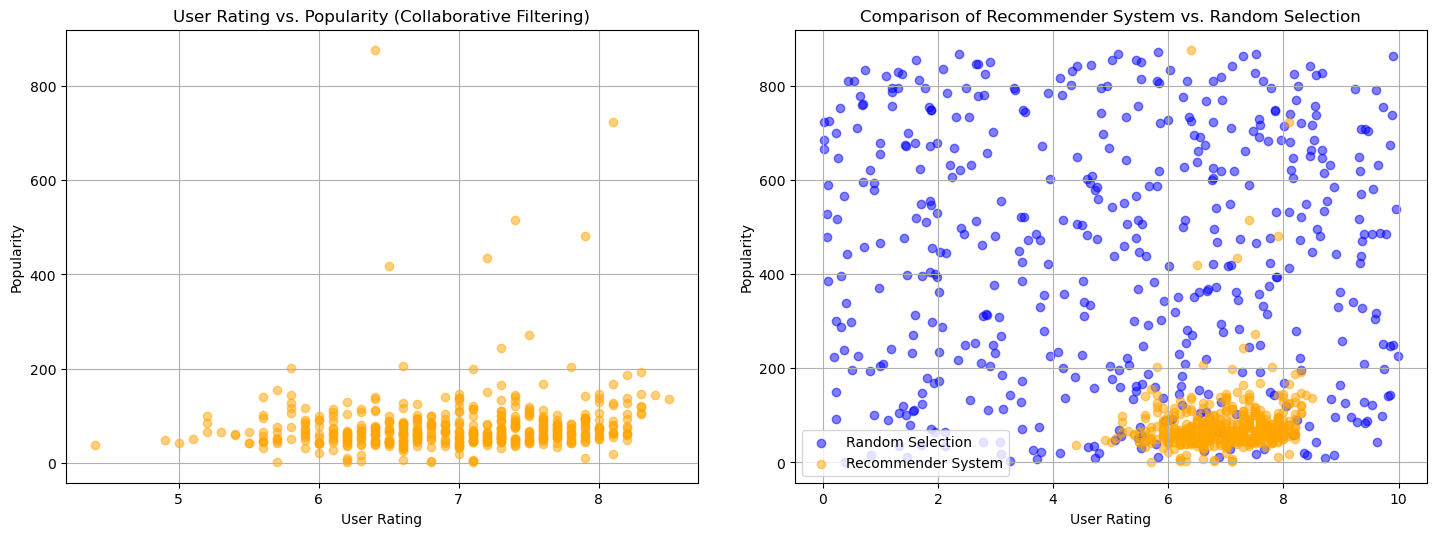

In [5]:
# Collaborative Filtering Module
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for collaborative filtering
axs[0].scatter(q_movies['vote_average'], q_movies['popularity'], color='orange', alpha=0.5)
axs[0].set_title('User Rating vs. Popularity (Collaborative Filtering)')
axs[0].set_xlabel('User Rating')
axs[0].set_ylabel('Popularity')
axs[0].grid(True)

# Content-Based Filtering Module
# Generate random data for comparison
random_user_rating = np.random.uniform(low=0, high=10, size=len(q_movies))
random_popularity = np.random.uniform(low=0, high=tmdb_data['popularity'].max(), size=len(q_movies))

# Scatter plot for random selection
axs[1].scatter(random_user_rating, random_popularity, color='blue', alpha=0.5, label='Random Selection')
axs[1].scatter(q_movies['vote_average'], q_movies['popularity'], color='orange', alpha=0.5, label='Recommender System')
axs[1].set_title('Comparison of Recommender System vs. Random Selection')
axs[1].set_xlabel('User Rating')
axs[1].set_ylabel('Popularity')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout(pad=3)
plt.show()

# Collaborative Filtering

In [6]:
def collaborative_filtering(movie_title):
    # Compute similarity matrix
    similarity_matrix = cosine_similarity(numeric_data)
    
    # Find index of the input movie
    movie_index = tmdb_data[tmdb_data['title'] == movie_title].index[0]
    
    # Retrieve similar movies with their similarity scores
    similar_movies = list(enumerate(similarity_matrix[movie_index]))
    
    # Sort similar movies by similarity score in descending order
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    
    # Extract top similar movies excluding the input movie itself
    top_similar_movies = sorted_similar_movies[1:11]
    
    # Return top similar movies
    return top_similar_movies

In [7]:
# Example
movie_title = "Iron Man"
collab_filtering_result = collaborative_filtering(movie_title)
print("Top 10 movies similar to", movie_title, "based on Collaborative Filtering:")
for movie in collab_filtering_result:
    print("- Movie:", tmdb_data.iloc[movie[0]]['title'])
    print("  Similarity Score:", movie[1]) # In collaborative filtering, similarity score represents correlatio

Top 10 movies similar to Iron Man based on Collaborative Filtering:
- Movie: Resident Evil
  Similarity Score: 0.999999999999915
- Movie: Pain & Gain
  Similarity Score: 0.9999999999998688
- Movie: Orphan
  Similarity Score: 0.9999999999997123
- Movie: Mrs. Doubtfire
  Similarity Score: 0.9999999999994492
- Movie: Friends with Benefits
  Similarity Score: 0.9999999999991928
- Movie: Bad Moms
  Similarity Score: 0.9999999999991641
- Movie: There Will Be Blood
  Similarity Score: 0.9999999999990271
- Movie: Sherlock Holmes
  Similarity Score: 0.9999999999990221
- Movie: Taken 2
  Similarity Score: 0.9999999999989624
- Movie: The Deer Hunter
  Similarity Score: 0.9999999999989602


In [8]:
#joblib file for Collaborative filtering
dump(collab_filtering_result,'movie_recommender_model_collaborative.joblib')
print("Collaborative filtering model saved successfully.")

Collaborative filtering model saved successfully.


# Content-Based Filtering

In [9]:
def content_based_filtering(movie_title):
    # Initialize CountVectorizer
    cv = CountVectorizer()
    
    # Fit and transform genres into a matrix
    genres_matrix = cv.fit_transform(tmdb_data['genres'])
    
    # Compute cosine similarity between movies based on genres
    similarity_scores = cosine_similarity(genres_matrix, genres_matrix)
    
    # Find index of the input movie
    movie_index = tmdb_data[tmdb_data['title'] == movie_title].index[0]
    
    # Retrieve similar movies with their similarity scores
    similar_movies = list(enumerate(similarity_scores[movie_index]))
    
    # Sort similar movies by similarity score in descending order
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    
    # Extract top similar movies excluding the input movie itself
    top_similar_movies = sorted_similar_movies[1:11]

    # Return top similar movies
    return top_similar_movies

In [10]:
# Example
movie_title = "Iron Man"
content_based_filtering_result = content_based_filtering(movie_title)

# Print correlation with similar movies
print("Correlation with similar movies for", movie_title, "based on Content-Based Filtering:")
for movie in content_based_filtering_result:
    print("- Movie:", tmdb_data.iloc[movie[0]]['title'])
    print("  Similarity Score:", movie[1]) # In content-based filtering, similarity score represents correlation

Correlation with similar movies for Iron Man based on Content-Based Filtering:
- Movie: Avengers: Age of Ultron
  Similarity Score: 1.0
- Movie: The Avengers
  Similarity Score: 1.0
- Movie: Captain America: Civil War
  Similarity Score: 1.0
- Movie: Iron Man 3
  Similarity Score: 1.0
- Movie: Transformers: Revenge of the Fallen
  Similarity Score: 1.0
- Movie: Transformers: Age of Extinction
  Similarity Score: 1.0
- Movie: TRON: Legacy
  Similarity Score: 1.0
- Movie: Star Trek Into Darkness
  Similarity Score: 1.0
- Movie: Pacific Rim
  Similarity Score: 1.0
- Movie: Transformers: Dark of the Moon
  Similarity Score: 1.0


In [11]:
#joblib file for Content-based filtering
dump(content_based_filtering_result,'movie_recommender_model_content-based.joblib')
print("Content-based filtering model saved successfully.")

Content-based filtering model saved successfully.


# Data Execute/testing

In [12]:
# Function to handle errors and variations in user input
def find_closest_match(user_input):
    # List of movie titles from the dataset
    movie_titles = tmdb_data['title'].tolist()
    
    # Find closest match using difflib's get_close_matches function
    closest_matches = df.get_close_matches(user_input, movie_titles, n=1, cutoff=0.6)
    
    if closest_matches:
        # Return the closest match
        return closest_matches[0]
    else:
        # Return None if no close match found
        return None

In [13]:
# Enter Movie Title
movie_title = input("Enter the title of the movie: ")

# Find closest match to user input
closest_match = find_closest_match(movie_title)

# Check if a close match is found
if closest_match:
    print("Closest match found:", closest_match)
    # Collaborative Filtering
    collab_filtering_result = collaborative_filtering(closest_match)
    print("\nTop 10 movies similar to", closest_match, "based on Collaborative Filtering:")
    for movie in collab_filtering_result:
        print(tmdb_data.iloc[movie[0]]['title'])
else:
    print("Theres no movie such as", movie_title, "Please Enter another title")

Enter the title of the movie: Iron Man
Closest match found: Iron Man

Top 10 movies similar to Iron Man based on Collaborative Filtering:
Resident Evil
Pain & Gain
Orphan
Mrs. Doubtfire
Friends with Benefits
Bad Moms
There Will Be Blood
Sherlock Holmes
Taken 2
The Deer Hunter


In [14]:
# Enter Movie Title
movie_title = input("Enter the title of the movie: ")

# Find closest match to user input
closest_match = find_closest_match(movie_title)

# Check if a close match is found
if closest_match:
    print("Closest match found:", closest_match)
    # Content-Based Filtering
    content_based_filtering_result = content_based_filtering(closest_match)
    print("\nTop 10 movies similar to", closest_match, "based on Content-Based Filtering:")
    for movie in content_based_filtering_result:
        print(tmdb_data.iloc[movie[0]]['title'])
else:
    print("Theres no movie such as", movie_title, "Please Enter another title")


Enter the title of the movie: Iron Man
Closest match found: Iron Man

Top 10 movies similar to Iron Man based on Content-Based Filtering:
Avengers: Age of Ultron
The Avengers
Captain America: Civil War
Iron Man 3
Transformers: Revenge of the Fallen
Transformers: Age of Extinction
TRON: Legacy
Star Trek Into Darkness
Pacific Rim
Transformers: Dark of the Moon
